In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 

In [16]:
data = pd.read_csv('../data/raw/clinical_dataset.csv', sep=';')

In [17]:
# Remove outliers
filled_data = data
for columns in filled_data: 
    if (filled_data[columns].dtype == object):
        filled_data[columns].replace('Test not adequate', np.nan, inplace=True)
        filled_data[columns].replace('test non realizable', np.nan, inplace=True)
    elif (filled_data[columns].dtype == np.float64 or data[columns].dtype == np.int64):
        filled_data[columns].replace(999, np.nan, inplace=True)


In [20]:
# Remove null values
# TODO: Remove entries of features with missing values
# TODO: Remove features with many missing values
# Find rows where there are mon than 1 null value


for column in data:
    # Rplace nan values with the median of each column
    if data[column].dtype != object and data[column].dtype != bool:
        filled_data[column].fillna(data[column].median(), inplace=True)

    # Replace categorical values with the most used column value 
    elif (data[column].dtype != np.float64 and data[column].dtype != np.int64):
         filled_data[column].fillna(data[column].value_counts().index[0], inplace=True)


In [22]:
# Order categorical data
encoded_data = filled_data
for column in data:
    if data[column].dtype == np.object:
        print(f'Column: {column}'f' data: {data[column].unique()}')
ordered_categories = {
    'fried': ['Non frail', 'Pre-frail', 'Frail'],
    'gender': ['F', 'M'],
    'gait_optional_binary': [True, False],
    'ortho_hypotension': ['No', 'Yes'],
    'vision': ['Sees well', 'Sees moderately','Sees poorly'  ],
    'audition': ['Hears well', 'Hears moderately', 'Hears poorly' ],
    'weight_loss': ['No', 'Yes'],
    'balance_single': ['>5 sec', '<5 sec'],
    'gait_speed_slower': ['No', 'Yes'],
    'grip_strength_abnormal': ['No', 'Yes'],
    'low_physical_activity': ['No', 'Yes'],
    'memory_complain': ['No', 'Yes'],
    'sleep': ['No sleep problem', 'Occasional sleep problem', 'Permanent sleep problem'],
    'living_alone': ['No', 'Yes'],
    'leisure_club': ['Yes', 'No'],
    'house_suitable_participant': ['Yes', 'No'],
    'house_suitable_professional': ['Yes', 'No'],
    'health_rate': [  '5 - Excellent', '4 - Good', '3 - Medium', '2 - Bad', '1 - Very bad'],
    'health_rate_comparison': [ '5 - A lot better', '4 - A little better', '3 - About the same', '2 - A little worse',
  '1 - A lot worse'],
    'activity_regular': ['> 5 h per week', '> 2 h and < 5 h per week', '< 2 h per week',  'No'],
    'smoking': ['Never smoked', 'Past smoker (stopped at least 6 months)', 'Current smoker']    
}
# encode data
encoder = LabelEncoder()

for column in data:
    if data[column].dtype == np.object or data[column].dtype == np.bool:
        encoder.fit(data[column])
        encoder.classes_ = ordered_categories[column]
        encoded_data[column] = encoder.transform(data[column]) 
        
encoded_data.to_csv('../data/preprocessed/preprocessed.csv', sep=';')

In [23]:
# Feature selection

training_data = encoded_data.drop(columns=['part_id',
                                           'weight_loss',
                                           'exhaustion_score',
                                           'gait_speed_slower',
                                           'grip_strength_abnormal',
                                           'low_physical_activity'])

In [50]:
# Split dataset to train and test 
data_shape = training_data.shape[0]
splitter = int(np.ceil(0.8*data_shape))
train_data = training_data.iloc[:splitter]
test_data = training_data.iloc[splitter:]

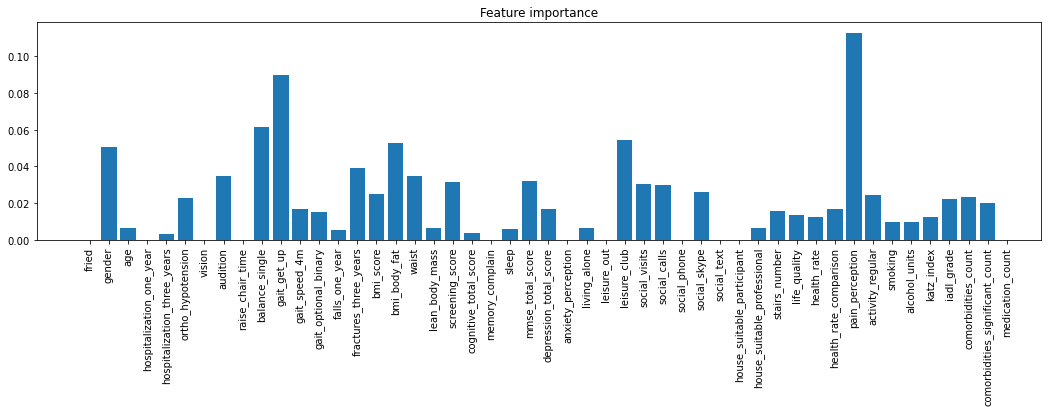

In [51]:
# Model Decision trees
tree_classifier = tree.DecisionTreeClassifier()
X = train_data.drop('fried' ,axis=1)
tree_classifier.fit(X, train_data['fried'])

train_columns = list(encoded_data.columns)
train_columns.remove("part_id")
fig, ax = plt.subplots( figsize=(18,4))
ax.bar(range(len(train_data.columns)-1),tree_classifier.feature_importances_ )
plt.xticks(range(len(train_data.columns)),train_data.columns,rotation=90)
ax.set_title("Feature importance")
plt.show()

54


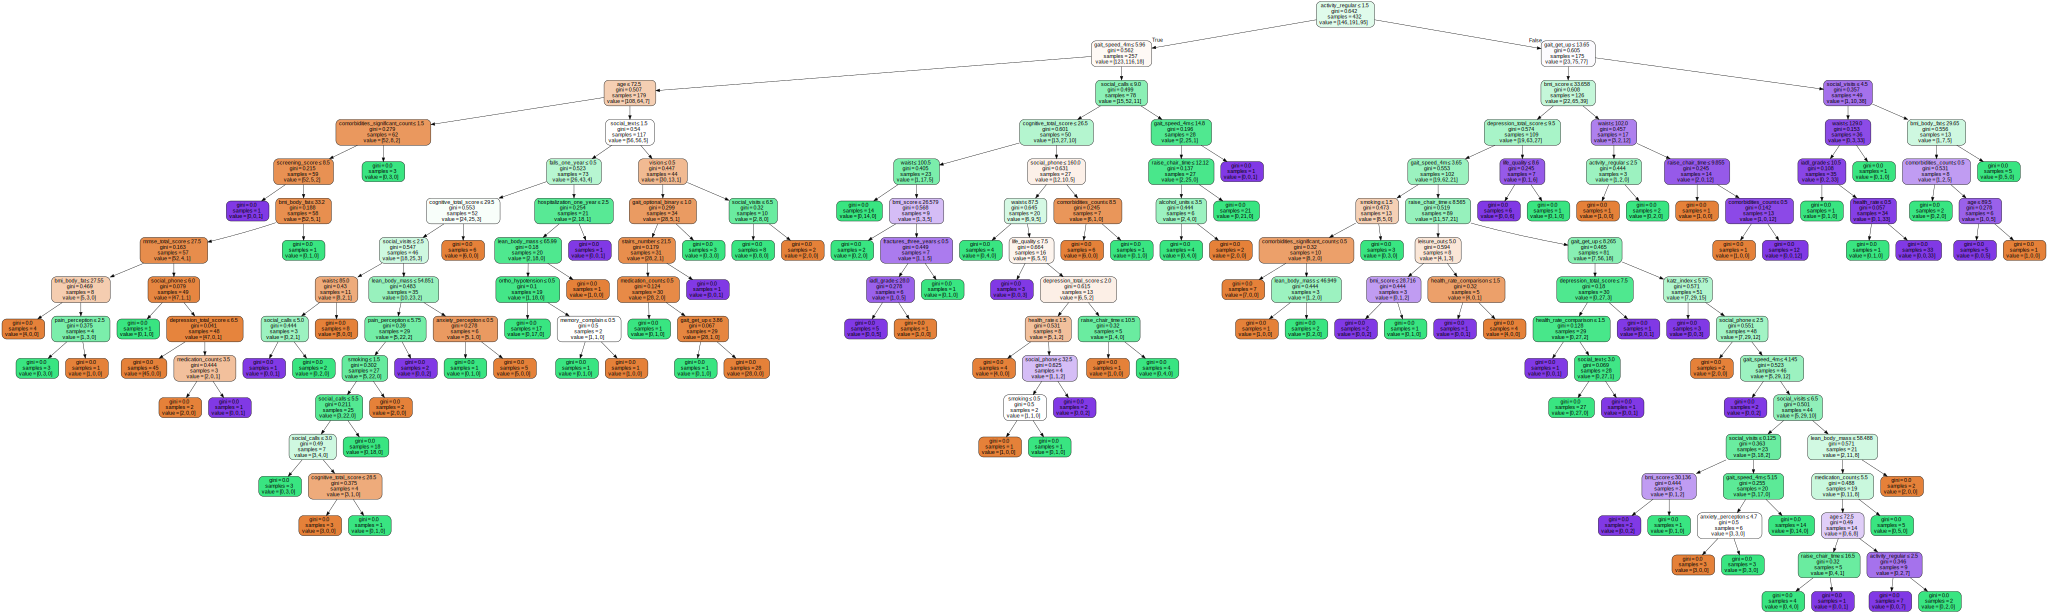

In [52]:
import graphviz 
print(len(train_columns))
dot_data = tree.export_graphviz(tree_classifier, 
                                out_file=None,
                                filled=True, 
                                rounded=True,  
                                special_characters=True,
                               feature_names =X.columns) 
graph = graphviz.Source(dot_data)
graph

#### Prediction